# Yes/No Classification Using SGD, Random Forest & SVC Classifiers Based on Fast Fourier Transform

 In this project we're looking for classifying "Yes" or "No" sounds using 3 different classification models and also compare their predictions vector with each other.

The dataset has been formatted as .wav files with 16 kHz sampling rate, so first of all we're going to get the array of each instance and then computing fft of them for our model input.

**Authors:** Seyed Mohammad Mehdi Hosseini (Smmehdihosseini@gmail.com) & Kamyar Arshi (Kamyararshi@gmail.com) 


**Dataset License:**  Creative Commons BY 4.0 license (For more info visit: https://creativecommons.org/licenses/by/4.0/)

#### >>> 1. Preparing Dataset

**Note!** You can directly download the dataset via: <http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz>, extracting the .gz file and giving directories <.\yes> and <.\no>. There are also other types of sounds in this dataset that it could be used for further and more advanced projects.

In [16]:
FILE_YES = 'Your Path To Yes Instances'        #Dataset directory for "YES" instances
FILE_NO = 'Your Path To No Instances'          #Dataset directory for "NO" instances

#### >>> 2. Importing Required Libraries

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.io.wavfile import read
from scipy.fftpack import fft

from sklearn.utils import shuffle

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#### >>> 3. Data Preprocessing Function

In [5]:
def prepare_the_data(directory):                                                

    files = os.listdir(directory)
    path = os.path.join(directory, files[0])
    
    (out_fs ,signal1) = read(path)
    signal1_fft = fft(signal1)
    signal1_fft = signal1_fft[:8000]
    signal1 = signal1.reshape(1,16000)
    signal1_fft = signal1_fft.reshape(1,8000)
    
    for i in files[1:]:
        path = os.path.join(directory, i)
        (out_fs ,signal) = read(path)
        
        if signal.size == 16000:                                               #Checking Sampling Rate for each instance
                                                                            
            fft_temp = fft(signal)                                             #FFT Computation for instances
            fft_temp = fft_temp[:8000]                                         #Selectingonly the positive half of FFT
            fft_temp = fft_temp.reshape(1,8000)                                
            signal1_fft = np.concatenate((signal1_fft, fft_temp), axis=0)
        
   
    return signal1_fft, out_fs

#### >>> 4. Storing .wav Files Into Numpy Arrays

In [17]:

X_yes, fs_yes = prepare_the_data(FILE_YES)                                     #Sampling frequencies are similar in all instances
yes_label = np.ones((X_yes.shape[0], 1))
X_no, fs_no = prepare_the_data(FILE_NO)                                        #Sampling frequencies are similar in all instances
no_label = np.zeros((X_no.shape[0], 1))

print('+ Dimensions of "YES" Instances:', X_yes.shape)
print('+ Dimensions of "NO" Instances:', X_no.shape)

+ Dimensions of "YES" Instances: (2157, 8000)
+ Dimensions of "NO" Instances: (2098, 8000)


#### >>> 5. Combining 'Yes' and 'No' Into A Single Array

In [18]:
data_set = np.concatenate((X_yes,X_no), axis=0)
data_labels = np.concatenate((yes_label, no_label), axis=0)
print('+ Dataset Dimension:', data_set.shape)
print('+ Datalabels Dimension:', data_labels.shape)

+ Dataset Dimension: (4255, 8000)
+ Datalabels Dimension: (4255, 1)


#### >>> 6. Shuffling The Data Instances and Then Split It Into Train and Test Sets

**Note!** In This Case, Splitation Ratio is 0.8 Which Means That We Use 80% of Our Data for Training and 20% of It For Test Set.

In [21]:
#Shuffling the Data instances and then split it into train & test sets

def data_rand_split(dataset, datalabels, ratio):
    
    data_set_shuff, data_labels_shuff = shuffle(dataset, datalabels, random_state=42)
    label_rat = int(ratio*data_labels_shuff.shape[0])
    set_rat = int(ratio*data_set_shuff.shape[0])
    X_train, y_train, X_test, y_test = data_set_shuff[:set_rat], data_labels_shuff[:label_rat], data_set_shuff[set_rat:], data_labels_shuff[label_rat:]
    return X_train, y_train.flatten(), X_test, y_test.flatten()                #Lables should be flattend to fit the Data

X_train, y_train, X_test, y_test = data_rand_split(data_set, data_labels, 0.8) 
print('+ Training Set Dimension:', X_train.shape)
print('+ Test Set Dimension:', X_test.shape)

+ Training Set Dimension: (3404, 8000)
+ Test Set Dimension: (851, 8000)


#### >>> 7. Computing Magnitude of Arrays

**Note!** In This Project, We're Using Just Using The Magnitude of the Data To Train Our Model. It's Possible To Use Phase of The Audio To Increase Accuracy.

In [23]:
X_train_abs = np.abs(X_train)                                                  
X_test_abs = np.abs(X_test)                                                    
y_train_yes = (y_train == 1)
y_test_yes = (y_test == 1)

#### >>> 8. Evaluation Functions

In [25]:
def trainmodel_evaluation():                                                     
    trainnum = random.randint(0, y_train_yes.shape[0])
    instance = X_train_abs[trainnum]
    label = y_train_yes[trainnum]
    return instance, label

def testmodel_evaluation():                                                       
    trainnum = random.randint(0, y_test_yes.shape[0])
    instance = X_test_abs[trainnum]
    label = y_test_yes[trainnum]
    return instance, label

#### >>> 9. Desired Plot Functions

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    threshold = thresholds[np.argmax(precisions == recalls)]
    plt.plot(precisions[:-1], "b-", label="Precision")
    plt.plot(recalls[:-1], "r-", label="Recall")
    plt.plot(threshold, "g-", label="Threshold")
    blue_patch = mpatches.Patch(color='blue', label='Precision')
    red_patch = mpatches.Patch(color='red', label='Recall')
    green_patch = mpatches.Patch(color='green', label='Threshold')
    plt.legend(handles=[blue_patch, red_patch, green_patch])
    plt.xlabel("Threshold")
    plt.ylabel("Rate")
    plt.ylim((0,1))
    plt.grid()
    plt.show()
    
def plot_roc_curve(falsepr, truepr, label=None):
    plt.plot(falsepr, truepr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("Threshold")
    plt.ylabel("Recall (True Positive Rate)")
    plt.ylim((0,1))
    plt.grid()
    plt.show()

#### >>> 10. Choosing Random Instance For Model Evaluation

In [34]:
#Choosing Random Instance For Model Evaluation
some_instance_train, some_label_train = trainmodel_evaluation()
some_instance_test, some_label_test = testmodel_evaluation()

#### >>> 11. SGD Classifier Model Training and Evaluation

+ Random Selected Train Instance Label:
 [False] 

+ SGD Classifier Model Prediction For Random Selected Train Instance:
 [False] 

+ Random Selected Test Instance Label:
 [True] 

+ SGD Classifier Model Prediction For Random Selected Test Instance:
 [ True] 

+ SGD Classifier Model Accuracy:
 [0.90044053 0.90132159 0.90740741] 

+ SGD Classifier Model Confusion Matrix:
 [[1473  194]
 [ 136 1601]] 

+ SGD Classifier Model Precision Score:
 0.8919220055710306 

+ SGD Classifier Model Recall Score:
 0.9217040875071963 

+ SGD Classifier Model F1 Score:
 0.906568516421291 

+ SGD Classifier Model Precision, Recall Vs Threshold:



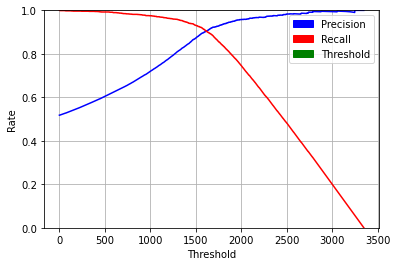

+ SGD Classifier Model ROC Curve:



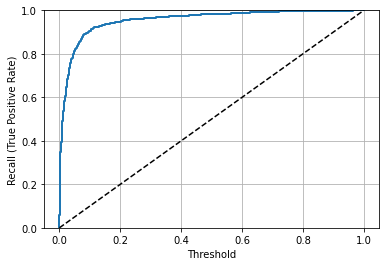

+ SVC Classifier Model ROC(AUC) Score:
 0.955421350962968 



In [35]:
#Training Model

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train_abs, y_train_yes)

#Testing The Model Validity Using Our Train Set
print('+ Random Selected Train Instance Label:\n', [some_label_train], '\n')
print('+ SGD Classifier Model Prediction For Random Selected Train Instance:\n', sgd_clf.predict([some_instance_train]), '\n')

print('+ Random Selected Test Instance Label:\n', [some_label_test], '\n')
print('+ SGD Classifier Model Prediction For Random Selected Test Instance:\n', sgd_clf.predict([some_instance_test]), '\n')

#Prediction Array
SGD_pred = cross_val_predict(sgd_clf, X_train_abs, y_train_yes, cv=3)

#Accuracy of Model Prediction
SGD_accuracy = cross_val_score(sgd_clf, X_train_abs, y_train_yes, cv=3, scoring="accuracy")
print('+ SGD Classifier Model Accuracy:\n', SGD_accuracy, '\n')

#Confusion Matrix 
SGD_confusion = confusion_matrix(y_train_yes, SGD_pred)
print('+ SGD Classifier Model Confusion Matrix:\n', SGD_confusion, '\n')

#Precision, Recall and F1 Score
SGD_precision = precision_score(y_train_yes, SGD_pred)
SGD_recall = recall_score(y_train_yes, SGD_pred)
SGD_f1_score = f1_score(y_train_yes, SGD_pred)
print('+ SGD Classifier Model Precision Score:\n', SGD_precision, '\n')
print('+ SGD Classifier Model Recall Score:\n', SGD_recall, '\n')
print('+ SGD Classifier Model F1 Score:\n', SGD_f1_score, '\n')

#Precision, Recall vs threshold
SGD_scores = cross_val_predict(sgd_clf, X_train_abs, y_train_yes, cv=3, method="decision_function")
SGD_precisions, SGD_recalls, SGD_thresholds = precision_recall_curve(y_train_yes, SGD_scores)
print('+ SGD Classifier Model Precision, Recall Vs Threshold:\n')
plot_precision_recall_vs_threshold(SGD_precisions, SGD_recalls, SGD_thresholds)

#ROC Curve
SGD_falsepr, SGD_truepr, SGD_thresholds = roc_curve(y_train_yes, SGD_scores)
print('+ SGD Classifier Model ROC Curve:\n')
plot_roc_curve(SGD_falsepr, SGD_truepr)

#ROC (AUC) Score
SGD_roc_auc = roc_auc_score(y_train_yes, SGD_scores)
print('+ SVC Classifier Model ROC(AUC) Score:\n', SGD_roc_auc, '\n')

#### >>> 12. Random Forest Classifier Model Training and Evaluation

+ Random Selected Train Instance Label:
 [False] 

+ Random Forest Classifier Model Prediction For Random Selected Train Instance:
 [False] 

+ Random Selected Test Instance Label:
 [True] 

+ Random Forest Classifier Model Prediction For Random Selected Test Instance:
 [ True] 

+ Random Forest Classifier Model Accuracy:
 [0.90044053 0.90132159 0.90740741] 

+ Random Forest Classifier Model Confusion Matrix:
 [[1550  117]
 [ 187 1550]] 

+ Random Forest Classifier Model Precision Score:
 0.9298140371925615 

+ Random Forest Model Recall Score:
 0.8923431203223949 

+ Random Forest Model F1 Score:
 0.9106933019976499 

+ Random Forest Classifier Model Precision, Recall Vs Threshold:



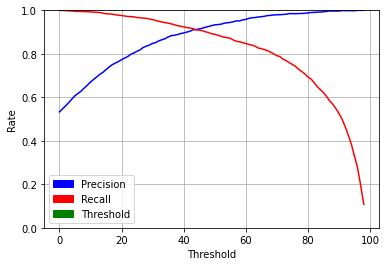

+ Random Forest Classifier Model ROC Curve:



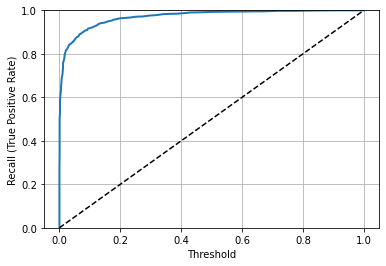

In [37]:
#Training Model

forest_clf = RandomForestClassifier(random_state=44)
forest_clf.fit(X_train_abs, y_train_yes)

#Testing The Model Validity Using Our Train Set

print('+ Random Selected Train Instance Label:\n', [some_label_train], '\n')
print('+ Random Forest Classifier Model Prediction For Random Selected Train Instance:\n', forest_clf.predict([some_instance_train]), '\n')

print('+ Random Selected Test Instance Label:\n', [some_label_test], '\n')
print('+ Random Forest Classifier Model Prediction For Random Selected Test Instance:\n', forest_clf.predict([some_instance_test]), '\n')

#Prediction Array
Forest_pred = cross_val_predict(forest_clf, X_train_abs, y_train_yes, cv=3)
Forest_probas = cross_val_predict(forest_clf, X_train_abs, y_train_yes, cv=3, method="predict_proba")
Forest_scores = Forest_probas[:,1]

#Accuracy of Model Prediction
Forest_accuracy = cross_val_score(forest_clf, X_train_abs, y_train_yes, cv=3, scoring="accuracy")
print('+ Random Forest Classifier Model Accuracy:\n', SGD_accuracy, '\n')

#Confusion Matrix 
Forest_confusion = confusion_matrix(y_train_yes, Forest_pred)
print('+ Random Forest Classifier Model Confusion Matrix:\n', Forest_confusion, '\n')

#Precision, Recall and F1 Score
Forest_precision = precision_score(y_train_yes, Forest_pred)
Forest_recall = recall_score(y_train_yes, Forest_pred)
Forest_f1_score = f1_score(y_train_yes, Forest_pred)
print('+ Random Forest Classifier Model Precision Score:\n', Forest_precision, '\n')
print('+ Random Forest Model Recall Score:\n', Forest_recall, '\n')
print('+ Random Forest Model F1 Score:\n', Forest_f1_score, '\n')

#Precision, Recall vs threshold
#Forest_scores = cross_val_predict(forest_clf, X_train_abs, y_train_yes, cv=3, method="decision_function")
Forest_precisions, Forest_recalls, Forest_thresholds = precision_recall_curve(y_train_yes, Forest_scores)
print('+ Random Forest Classifier Model Precision, Recall Vs Threshold:\n')
plot_precision_recall_vs_threshold(Forest_precisions, Forest_recalls, Forest_thresholds)

#ROC Curve
Forest_falsepr, Forest_truepr, Forest_thresholds = roc_curve(y_train_yes, Forest_scores)
print('+ Random Forest Classifier Model ROC Curve:\n')
plot_roc_curve(Forest_falsepr, Forest_truepr)

#### >>> 13. Support Vector Classifier Model Training and Evaluation

+ Random Selected Train Instance Label:
 [False] 

+ Random Forest Classifier Model Prediction For Random Selected Train Instance:
 [0.] 

+ Random Selected Test Instance Label:
 [True] 

+ Random Forest Classifier Model Prediction For Random Selected Test Instance:
 [1.] 

+ SVC Classifier Model Accuracy:
 [0.88281938 0.90660793 0.88447972] 

+ SGD Classifier Model Confusion Matrix:
 [[1627   40]
 [ 186 1551]] 

+ SVC Classifier Model Precision Score:
 0.9748585795097423 

+ SVC Classifier Model Recall Score:
 0.8929188255613126 

+ SVC Classifier Model F1 Score:
 0.9320913461538463 

+ SVC Classifier Model Precision, Recall Vs Threshold:



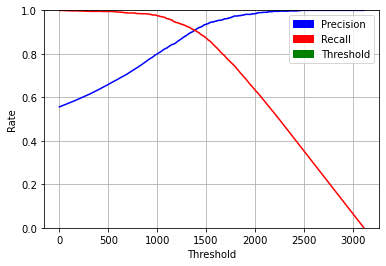

+ SVC Classifier Model ROC Curve:



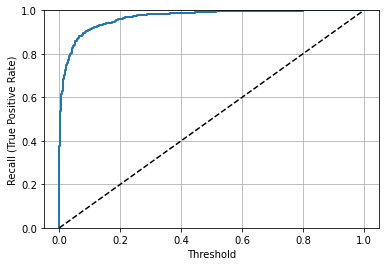

+ SVC Classifier Model ROC(AUC) Score:
 0.9680302281512609 



In [39]:
#Training Model

svc_clf = SVC()
svc_clf.fit(X_train_abs, y_train)

#Testing The Model Validity Using Our Train Set
print('+ Random Selected Train Instance Label:\n', [some_label_train], '\n')
print('+ Random Forest Classifier Model Prediction For Random Selected Train Instance:\n', svc_clf.predict([some_instance_train]), '\n')

print('+ Random Selected Test Instance Label:\n', [some_label_test], '\n')
print('+ Random Forest Classifier Model Prediction For Random Selected Test Instance:\n', svc_clf.predict([some_instance_test]), '\n')

#Prediction Array
SVC_pred = svc_clf.predict(X_train_abs)

#Accuracy of Model Prediction
SVC_accuracy = cross_val_score(svc_clf, X_train_abs, y_train, cv=3, scoring="accuracy")
print('+ SVC Classifier Model Accuracy:\n', SVC_accuracy, '\n') 

#Confusion Matrix 
SVC_confusion = confusion_matrix(y_train_yes, SVC_pred)
print('+ SGD Classifier Model Confusion Matrix:\n', SVC_confusion, '\n')

#Precision, Recall and F1 Score
SVC_precision = precision_score(y_train_yes, SVC_pred)
SVC_recall = recall_score(y_train_yes, SVC_pred)
SVC_f1_score = f1_score(y_train_yes, SVC_pred)
print('+ SVC Classifier Model Precision Score:\n', SVC_precision, '\n')
print('+ SVC Classifier Model Recall Score:\n', SVC_recall, '\n')
print('+ SVC Classifier Model F1 Score:\n', SVC_f1_score, '\n')

#Precision, Recall vs threshold
SVC_scores = cross_val_predict(svc_clf, X_train_abs, y_train_yes, cv=3, method="decision_function")
SVC_precisions, SVC_recalls, SVC_thresholds = precision_recall_curve(y_train_yes, SVC_scores)
print('+ SVC Classifier Model Precision, Recall Vs Threshold:\n')
plot_precision_recall_vs_threshold(SVC_precisions, SVC_recalls, SVC_thresholds)

#ROC Curve
SVC_falsepr, SVC_truepr, SVC_thresholds = roc_curve(y_train_yes, SVC_scores)
print('+ SVC Classifier Model ROC Curve:\n')
plot_roc_curve(SVC_falsepr, SVC_truepr)

#ROC (AUC) Score
SVC_roc_auc = roc_auc_score(y_train_yes, SVC_scores)
print('+ SVC Classifier Model ROC(AUC) Score:\n', SVC_roc_auc, '\n')

#### >>> 14. A Comparison Between Models

In [41]:
def comparator(Performance_Model):
    if Performance_Model == 'Precision':
        Model_Dict = {'SGD Classifier': SGD_precision, 'Random Forset Classifier': Forest_precision, 'SVC Classisfier': SVC_precision}
    elif Performance_Model == 'Recall':
        Model_Dict = {'SGD Classifier': SGD_recall, 'Random Forset Classifier': Forest_recall, 'SVC Classisfier': SVC_recall}
    elif Performance_Model == 'F1 Score':
        Model_Dict = {'SGD Classifier': SGD_f1_score, 'Random Forset Classifier': Forest_f1_score, 'SVC Classisfier': SVC_f1_score}
    elif Performance_Model == 'ROC(AUC)':
        Model_Dict = {'SGD Classifier': SGD_roc_auc, 'Random Forset Classifier': Forest_roc_auc, 'SVC Classisfier': SVC_roc_auc}
        
    print("+ Comparison Between Models For", Performance_Model,":\n")
    for elem in sorted(Model_Dict.items() ,reverse=True, key=lambda x: x[1]):
        print(elem[0], "::", elem[1])
    return print('\n')

comparator('Precision')
comparator('Recall')
comparator('F1 Score')

+ Comparison Between Models For Precision :

SVC Classisfier :: 0.9748585795097423
Random Forset Classifier :: 0.9298140371925615
SGD Classifier :: 0.8919220055710306


+ Comparison Between Models For Recall :

SGD Classifier :: 0.9217040875071963
SVC Classisfier :: 0.8929188255613126
Random Forset Classifier :: 0.8923431203223949


+ Comparison Between Models For F1 Score :

SVC Classisfier :: 0.9320913461538463
Random Forset Classifier :: 0.9106933019976499
SGD Classifier :: 0.906568516421291




**Contact us:**

Seyed Mohammad Mehdi Hosseini (Smmehdihosseini@gmail.com)

Kamyar Arshi (Kamyararshi@gmail.com)

